In [14]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten, Bidirectional, Input, Reshape, Attention
from keras.models import Model, load_model
import optuna
import warnings

warnings.filterwarnings('ignore')

paths = []
labels = []

for dirname, _, filenames in os.walk('D:\\zidio\\TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1].split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:  # Limit to 2800 samples
        break

df = pd.DataFrame({'speech': paths, 'label': labels})
print('Dataset Loaded')
print(df.head())


Dataset Loaded
                                              speech  label
0  D:\zidio\TESS Toronto emotional speech set dat...  angry
1  D:\zidio\TESS Toronto emotional speech set dat...  angry
2  D:\zidio\TESS Toronto emotional speech set dat...  angry
3  D:\zidio\TESS Toronto emotional speech set dat...  angry
4  D:\zidio\TESS Toronto emotional speech set dat...  angry


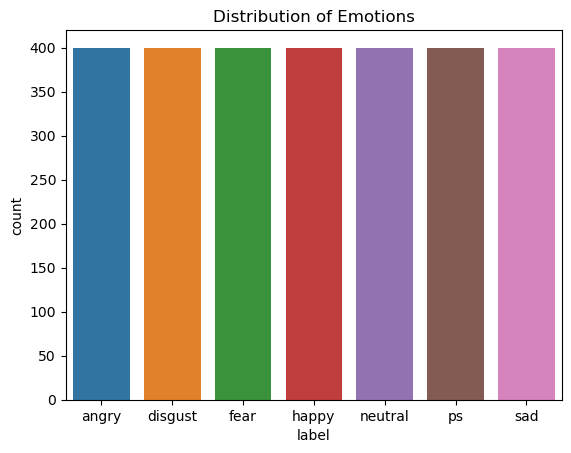

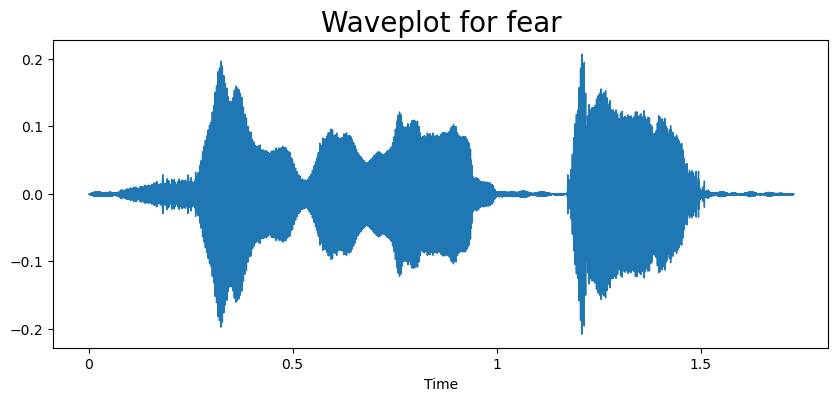

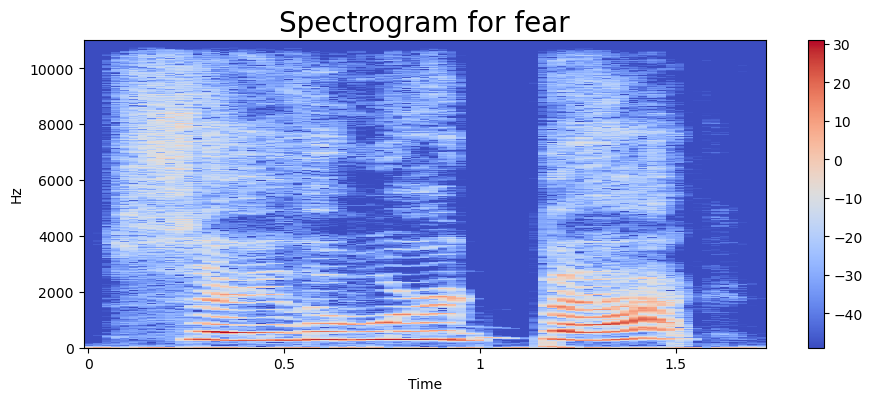

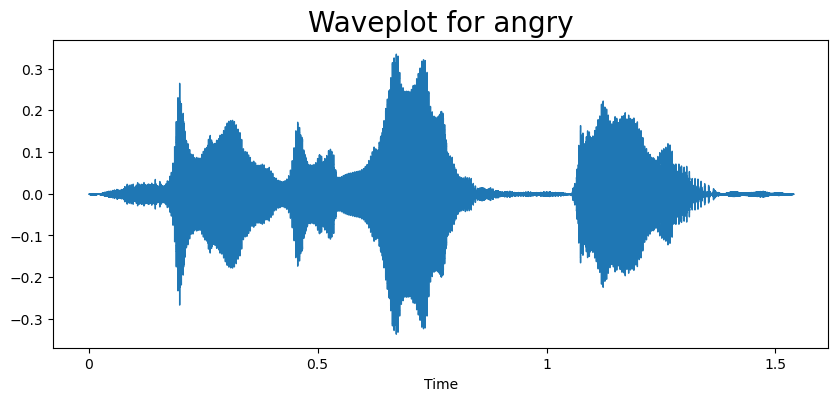

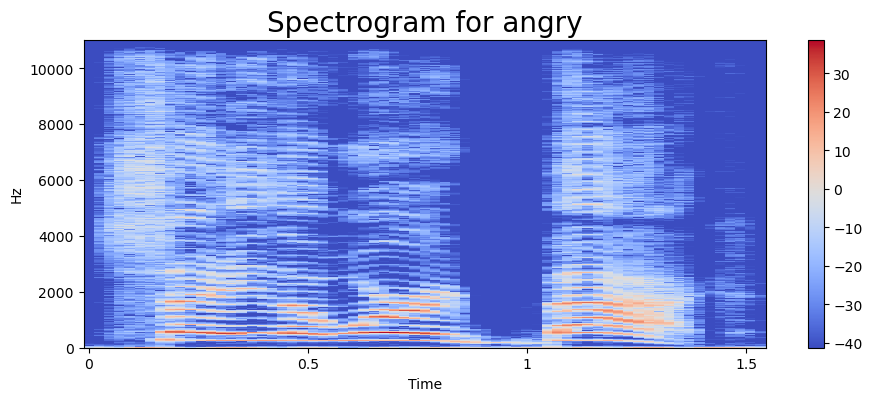

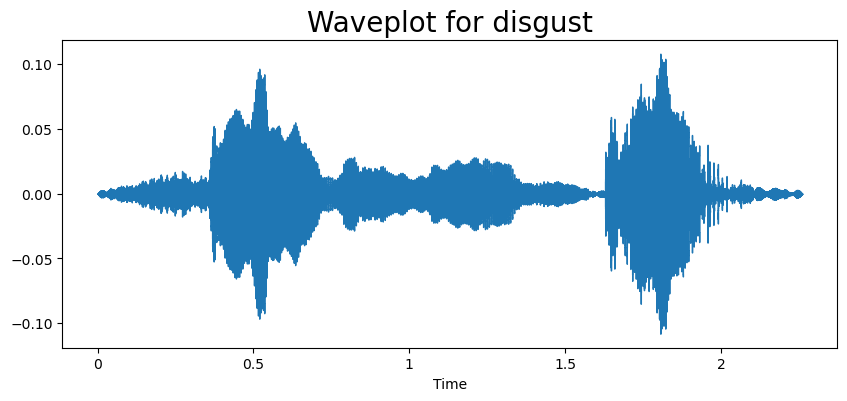

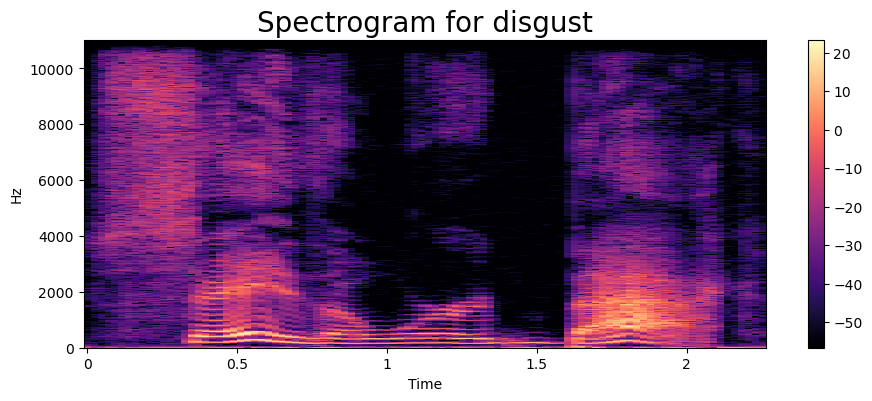

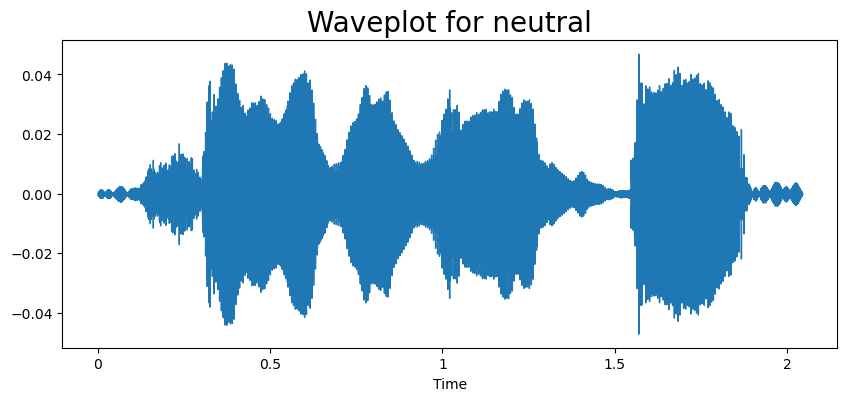

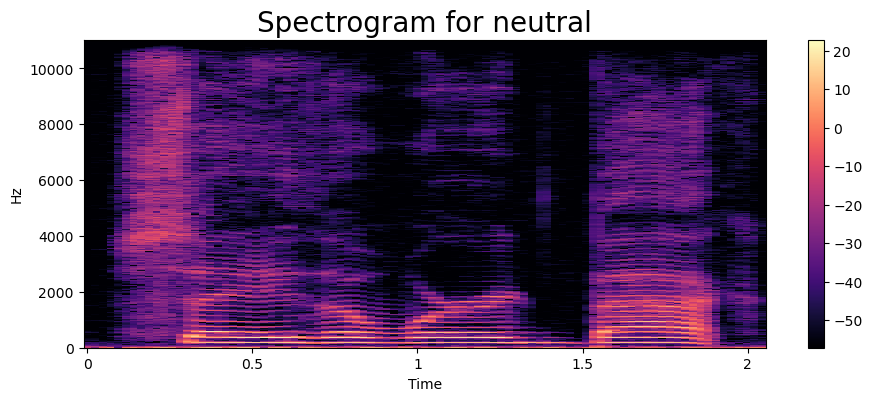

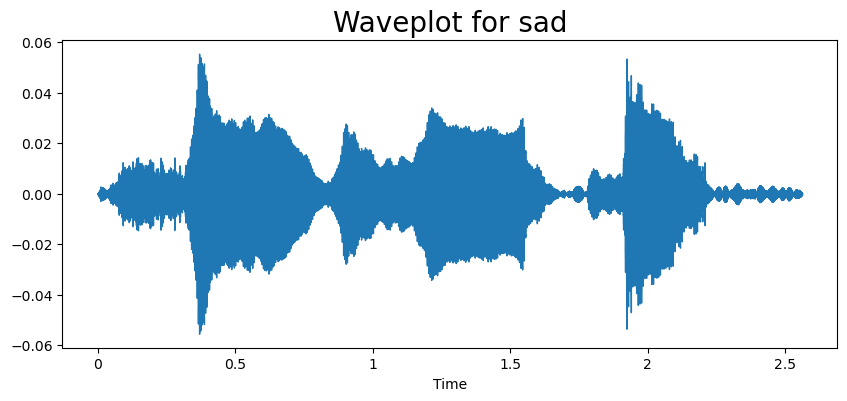

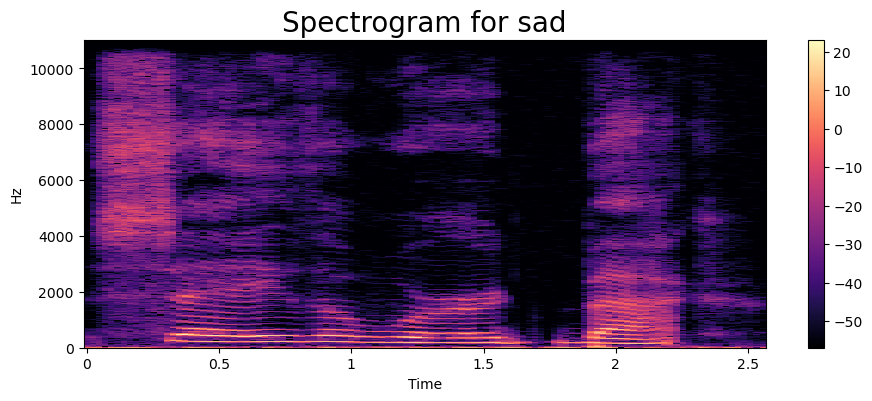

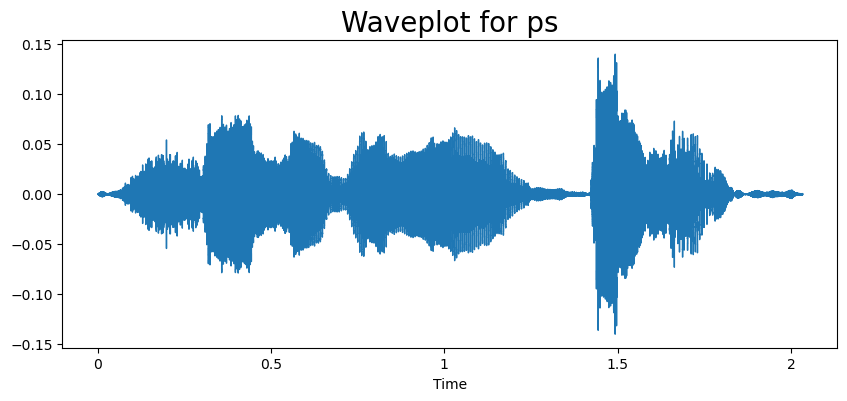

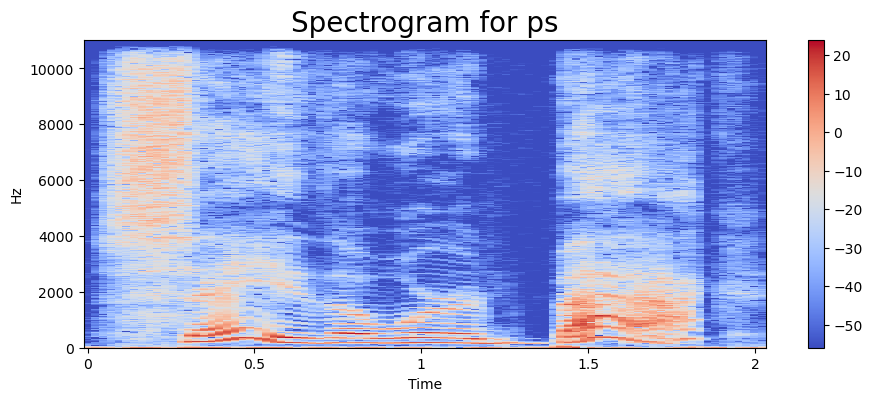

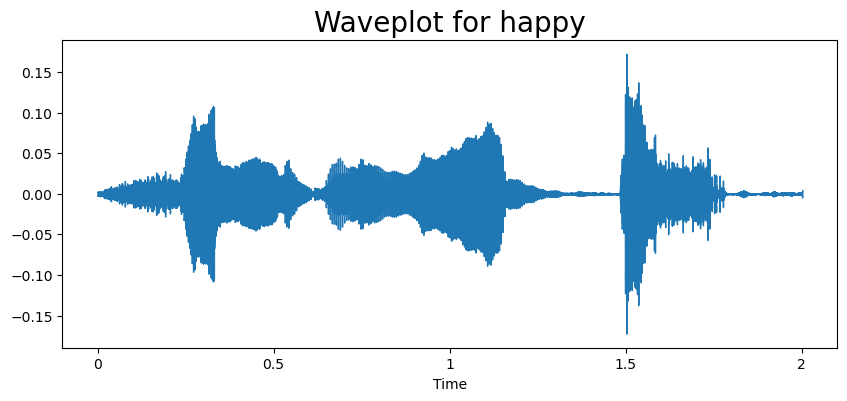

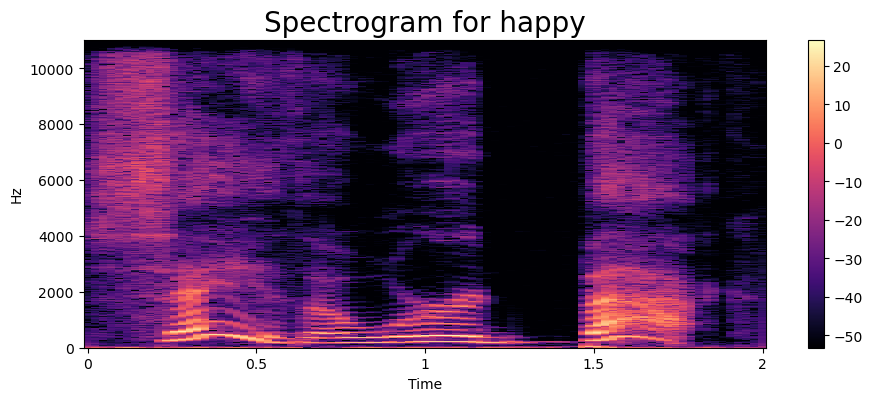

In [15]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']]).toarray()

sns.countplot(data=df, x='label')
plt.title('Distribution of Emotions')
plt.show()

def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(f'Waveplot for {emotion}', size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(f'Spectrogram for {emotion}', size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()


emotions = ['fear', 'angry', 'disgust', 'neutral', 'sad', 'ps', 'happy']
for emotion in emotions:
    path = np.array(df['speech'][df['label'] == emotion])[0]
    data, sampling_rate = librosa.load(path)
    waveplot(data, sampling_rate, emotion)
    spectrogram(data, sampling_rate, emotion)
    display(Audio(path))


In [16]:
def extract_features(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
    mfcc_delta2_mean = np.mean(mfcc_delta2, axis=1)
    chroma_mean = np.mean(chroma, axis=1)
    features = np.hstack([mfcc_mean, mfcc_delta_mean, mfcc_delta2_mean, chroma_mean])
    return features

X_features = df['speech'].apply(lambda x: extract_features(x))
X = np.array([x for x in X_features])
X = np.expand_dims(X, -1)
y = enc.fit_transform(df[['label']])
y = y.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
def objective(trial):
    conv_filters_1 = trial.suggest_categorical('conv_filters_1', [16, 32, 64])
    conv_filters_2 = trial.suggest_categorical('conv_filters_2', [32, 64, 128])
    lstm_units = trial.suggest_categorical('lstm_units', [128, 256])
    dense_units = trial.suggest_categorical('dense_units', [64, 128])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    conv1 = Conv1D(filters=conv_filters_1, kernel_size=3, activation='relu')(input_layer)
    conv2 = Conv1D(filters=conv_filters_2, kernel_size=3, activation='relu')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv2)
    flatten = GlobalMaxPooling1D()(pool1)
    reshape = Reshape((1, -1))(flatten)
    lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(reshape)
    attention = Attention()([lstm, lstm])
    context_vector = GlobalAveragePooling1D()(attention)
    flatten_context = Flatten()(context_vector)
    dense = Dense(dense_units, activation='relu')(flatten_context)
    dropout = Dropout(dropout_rate)(dense)
    output = Dense(y.shape[1], activation='softmax')(dropout)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stop, reduce_lr], verbose=0)
    
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy


In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Value:", study.best_value)


[I 2024-08-20 22:18:00,667] A new study created in memory with name: no-name-99ad5d71-bb1c-499f-bdd8-4e0784af3c66
[I 2024-08-20 22:18:20,799] Trial 0 finished with value: 0.96875 and parameters: {'conv_filters_1': 64, 'conv_filters_2': 32, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.4664174342893552, 'learning_rate': 0.000794621810048221}. Best is trial 0 with value: 0.96875.
[I 2024-08-20 22:18:48,649] Trial 1 finished with value: 0.9263392686843872 and parameters: {'conv_filters_1': 64, 'conv_filters_2': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.4390592899862817, 'learning_rate': 6.213379988970594e-05}. Best is trial 0 with value: 0.96875.
[I 2024-08-20 22:18:59,600] Trial 2 finished with value: 0.1428571492433548 and parameters: {'conv_filters_1': 64, 'conv_filters_2': 32, 'lstm_units': 256, 'dense_units': 64, 'dropout_rate': 0.2516188866784318, 'learning_rate': 0.01952532529432522}. Best is trial 0 with value: 0.96875.
[I 2024-08-20 22:19:30,380] Trial

Best Parameters: {'conv_filters_1': 32, 'conv_filters_2': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.26683941566270214, 'learning_rate': 0.0022387455525376136}
Best Value: 0.984375


In [19]:
best_params = study.best_params

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
conv1 = Conv1D(filters=best_params['conv_filters_1'], kernel_size=3, activation='relu')(input_layer)
conv2 = Conv1D(filters=best_params['conv_filters_2'], kernel_size=3, activation='relu')(conv1)
pool1 = MaxPooling1D(pool_size=2)(conv2)
flatten = GlobalMaxPooling1D()(pool1)
reshape = Reshape((1, -1))(flatten)
lstm = Bidirectional(LSTM(best_params['lstm_units'], return_sequences=True))(reshape)
attention = Attention()([lstm, lstm])
context_vector = GlobalAveragePooling1D()(attention)
flatten_context = Flatten()(context_vector)
dense = Dense(best_params['dense_units'], activation='relu')(flatten_context)
dropout = Dropout(best_params['dropout_rate'])(dense)
output = Dense(y.shape[1], activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)])


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.2869 - loss: 1.7817 - val_accuracy: 0.6562 - val_loss: 1.0042 - learning_rate: 0.0022
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6293 - loss: 0.9150 - val_accuracy: 0.8371 - val_loss: 0.5127 - learning_rate: 0.0022
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7897 - loss: 0.5470 - val_accuracy: 0.8862 - val_loss: 0.3274 - learning_rate: 0.0022
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8673 - loss: 0.3889 - val_accuracy: 0.8750 - val_loss: 0.3209 - learning_rate: 0.0022
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8816 - loss: 0.3476 - val_accuracy: 0.9308 - val_loss: 0.2248 - learning_rate: 0.0022
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9045 - loss: 0.2713 - val_accuracy: 0.8973 - val_loss: 0.2383 - learning_rate: 0.0022
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9212 - loss: 0.2062 - val_ac

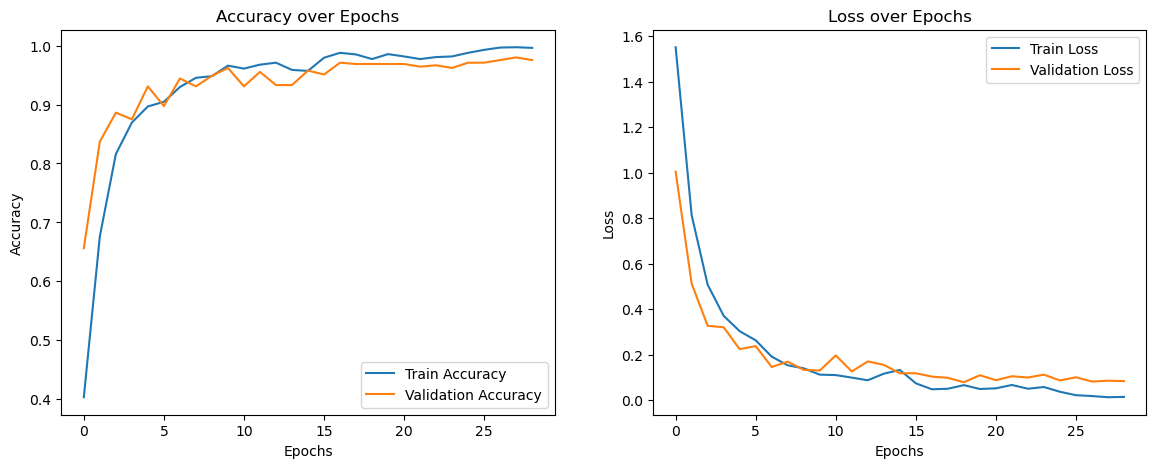

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


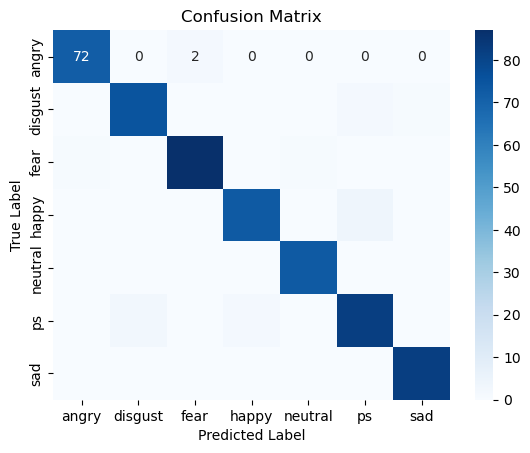

              precision    recall  f1-score   support

       angry       0.99      0.97      0.98        74
     disgust       0.96      0.96      0.96        78
        fear       0.98      0.98      0.98        89
       happy       0.97      0.95      0.96        77
     neutral       0.99      1.00      0.99        73
          ps       0.93      0.94      0.94        87
         sad       0.99      1.00      0.99        82

    accuracy                           0.97       560
   macro avg       0.97      0.97      0.97       560
weighted avg       0.97      0.97      0.97       560



In [20]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=enc.categories_[0]))


In [21]:
model_save_path = "D:\\zidio\\emotion_recognition_model.h5"

model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to D:\zidio\emotion_recognition_model.h5


In [22]:
loaded_model = load_model(model_save_path)
loaded_model.summary()


Model: "functional_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_101 (InputLayer)  │ (None, 132, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_202 (Conv1D)           │ (None, 130, 32)           │             128 │ input_layer_101[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_203 (Conv1D)           │ (None, 128, 64)           │           6,208 │ conv1d_202[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_101             │ (None, 64, 64)            │               0 │ conv1d_203[0][0]           │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_101      │ (None, 64)                │               0 │ max_pooling1d_101[0][0]    │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_101 (Reshape)         │ (None, 1, 64)             │               0 │ global_max_pooling1d_101[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_101             │ (None, 1, 256)            │         197,632 │ reshape_101[0][0]          │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_101 (Attention)     │ (None, 1, 256)            │               0 │ bidirectional_101[0][0],   │
│                               │                           │                 │ bidirectional_101[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_101  │ (None, 256)               │               0 │ attention_101[0][0]        │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_101 (Flatten)         │ (None, 256)               │               0 │ global_average_pooling1d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_202 (Dense)             │ (None, 64)                │          16,448 │ flatten_101[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_101 (Dropout)         │ (None, 64)                │               0 │ dense_202[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_203 (Dense)             │ (None, 7)                 │             455 │ dropout_101[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 220,873 (862.79 KB)

 Trainable params: 220,871 (862.78 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [23]:
from keras.models import load_model

model_save_path = "D:\\zidio\\emotion_recognition_model.h5"
model = load_model(model_save_path)


In [24]:
emotions = ['fear', 'ps', 'disgust', 'neutral', 'sad', 'angry', 'happy']

def extract_features(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
    mfcc_delta2_mean = np.mean(mfcc_delta2, axis=1)
    chroma_mean = np.mean(chroma, axis=1)

    features = np.hstack([mfcc_mean, mfcc_delta_mean, mfcc_delta2_mean, chroma_mean])
    
    return np.expand_dims(features, axis=-1) 


In [25]:
def predict_emotion(audio_path):
    features = extract_features(audio_path)
    features = np.expand_dims(features, axis=0)  
    prediction = model.predict(features)
    predicted_index = np.argmax(prediction, axis=1)[0]
    emotion_label = emotions[predicted_index]
    
    return emotion_label
    

In [26]:
audio_path = r"03-01-05-01-02-01-14.wav"  
predicted_emotion = predict_emotion(audio_path)
print(f"The predicted emotion is: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
The predicted emotion is: angry
